In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# Later, for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [5]:
sales_train = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

In [6]:
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [7]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [71]:
calendar
calendar_update = calendar.iloc[:1913, :]
calendar_update
calendar_dates = calendar_update[['date', 'd']]
calendar_dates = calendar_dates.set_index('d')
calendar_dates

,date
d,
d_1,2011-01-29
d_2,2011-01-30
d_3,2011-01-31
d_4,2011-02-01
d_5,2011-02-02
...,...
d_1909,2016-04-20
d_1910,2016-04-21
d_1911,2016-04-22


In [9]:
sales_train_1 = sales_train.iloc[:1, :]
sales_train_1_t = sales_train_1.T
sales_train_1_t = sales_train_1_t.iloc[6:, :]
sales_train_1_t = sales_train_1_t.iloc[900:, :]

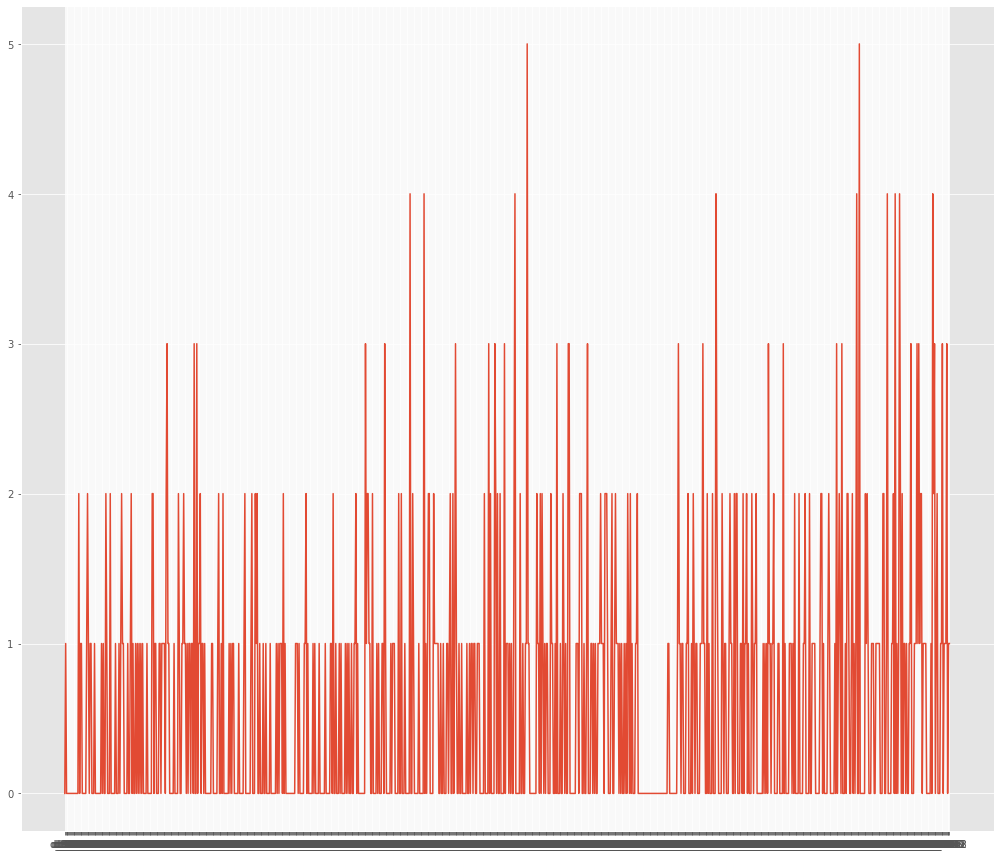

In [10]:
fig, ax = plt.subplots(figsize=(14, 12))
ax.plot(sales_train_1_t)
    
plt.tight_layout()

In [11]:
sales_train_cat = sales_train.groupby(['cat_id']).sum()
sales_train_cat

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,18901,...,28682,32007,34497,26151,24948,23632,23317,26704,31927,32654
HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,2615,...,3786,4634,4820,3323,3787,3472,3353,4085,4787,4683
HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,4056,...,9321,11721,12323,8585,8835,8239,8363,9728,12248,12458


In [53]:
sales_train_cat_hobbies = sales_train_cat.iloc[1, :].T
sales_train_cat_hobbies

d_1       3764
d_2       3357
d_3       2682
d_4       2669
d_5       1814
          ... 
d_1909    3472
d_1910    3353
d_1911    4085
d_1912    4787
d_1913    4683
Name: HOBBIES, Length: 1913, dtype: int64

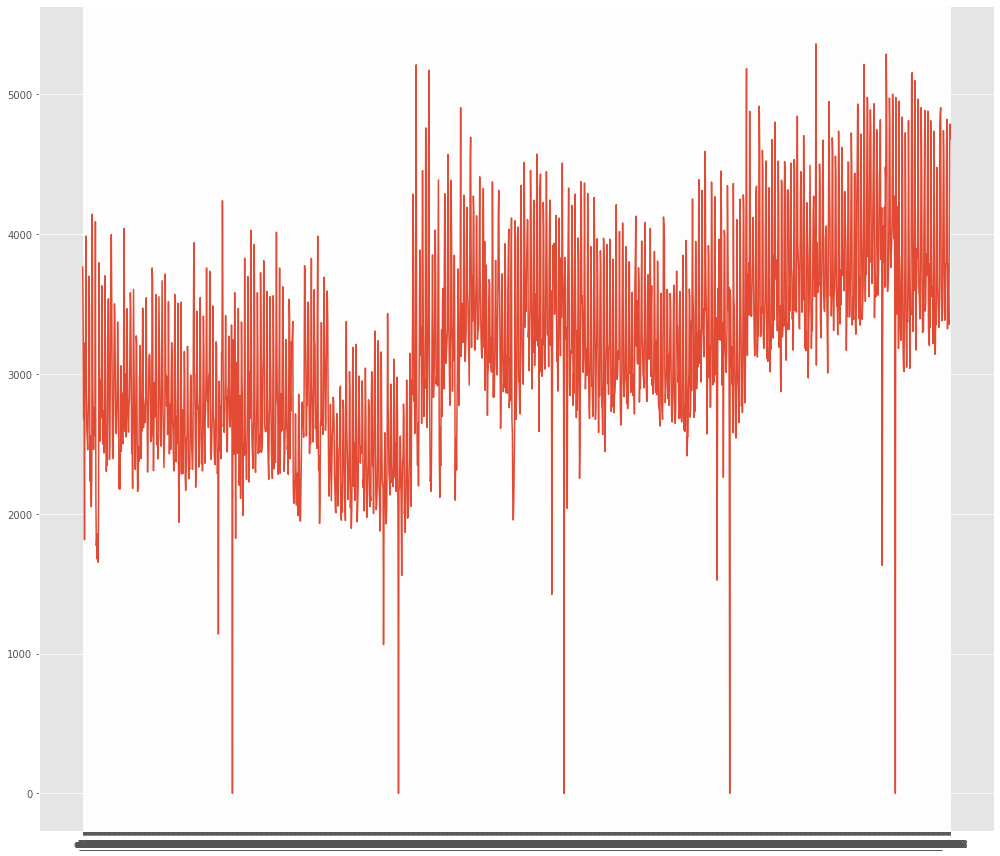

In [13]:
fig, ax = plt.subplots(figsize=(14, 12))
ax.plot(sales_train_cat_hobbies)
    
plt.tight_layout()

In [27]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)

In [29]:
plot_trend_data(ax, "Hobbies_Sales", sales_train_cat_food)

In [30]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

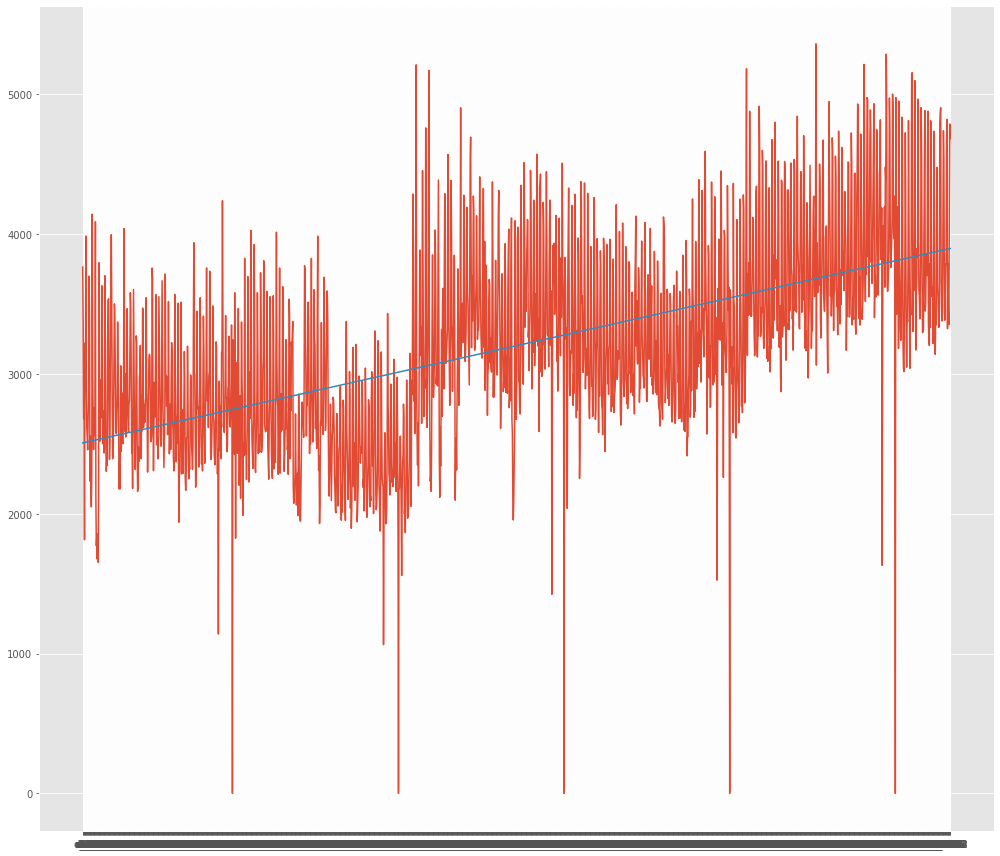

In [31]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Hobbies', sales_train_cat_hobbies)
plt.tight_layout()

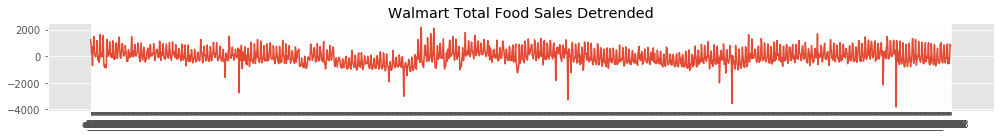

In [26]:
python_series = sales_train_cat_hobbies
python_linear_trend = fit_linear_trend(python_series)
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title("Walmart Total Food Sales Detrended")
plt.tight_layout()

In [41]:
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

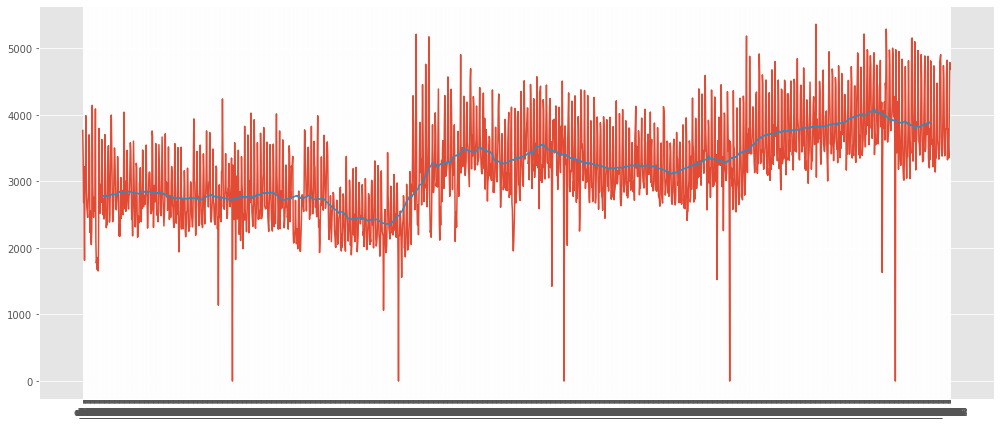

In [46]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_moving_average_trend(ax, 'Walmart Hobbies', sales_train_cat_hobbies, 90)
plt.tight_layout()

In [97]:
df = pd.DataFrame(sales_train_cat_hobbies)
df1 = df.join(calendar_dates)
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('date')
hobby_month = df1['HOBBIES'].index.month
hobby_dummies = pd.get_dummies(hobby_month).iloc[:,:11]
hobby_X = sm.add_constant(hobby_dummies.values, prepend=False)
hobby_seasonal_model = sm.OLS(sales_train_cat_hobbies.values, hobby_X).fit()
hobby_season = hobby_seasonal_model.predict(hobby_X)
hobby_season[:10]

array([3137.91772152, 3137.91772152, 3137.91772152, 3289.09411765,
       3289.09411765, 3289.09411765, 3289.09411765, 3289.09411765,
       3289.09411765, 3289.09411765])

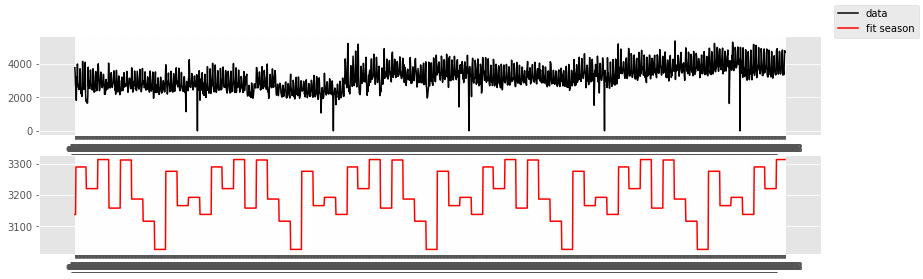

In [98]:
fig, axs = plt.subplots(2, figsize=(14, 4))
axs[0].plot(sales_train_cat_hobbies.index, sales_train_cat_hobbies, label='data', c='k')
axs[1].plot(sales_train_cat_hobbies.index, hobby_season, label='fit season', c='r')
fig.legend();

In [99]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).iloc[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

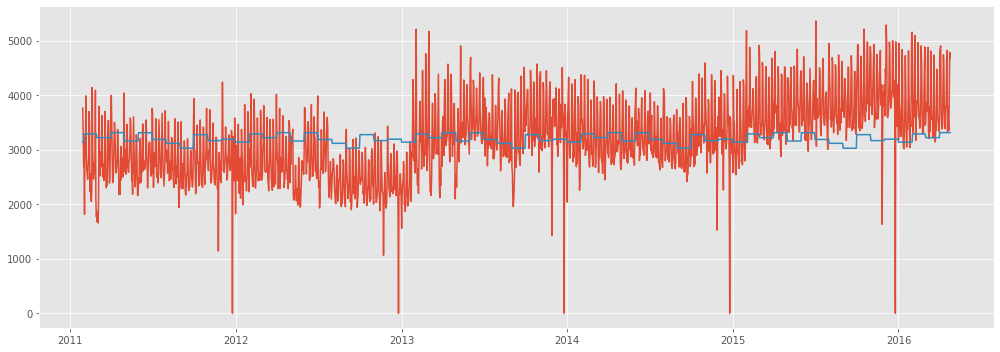

In [103]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_seasonal_trend(ax, 'hobbies', df1)
plt.tight_layout()

Text(0.5, 1.0, 'Walmart Hobby Sales, Deseasonalized')

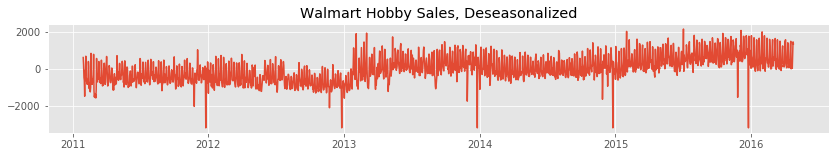

In [106]:
hobby_series = df1['HOBBIES']
hobby_seasonal_trend = fit_seasonal_trend(df1)
hobby_seasonal_detrended = hobby_series - hobby_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(df1.index, hobby_seasonal_detrended)
ax.set_title("Walmart Hobby Sales, Deseasonalized")

In [107]:
python_decomposition = sm.tsa.seasonal_decompose(df1)

In [108]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

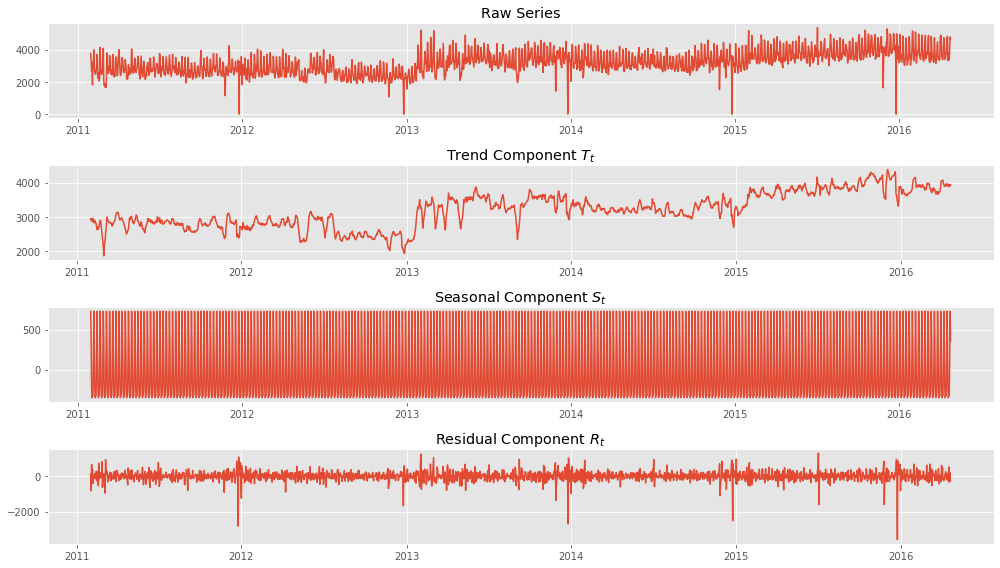

In [126]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, df1, python_decomposition)
plt.tight_layout()

In [119]:
df = pd.DataFrame(sales_train_cat_hobbies).join(calendar_dates)
df

,HOBBIES,date
d_1,3764,2011-01-29
d_2,3357,2011-01-30
d_3,2682,2011-01-31
d_4,2669,2011-02-01
d_5,1814,2011-02-02
...,...,...
d_1909,3472,2016-04-20
d_1910,3353,2016-04-21
d_1911,4085,2016-04-22
d_1912,4787,2016-04-23


In [120]:
df33 = df1.copy()

In [121]:
df33

,HOBBIES
date,
2011-01-29,3764
2011-01-30,3357
2011-01-31,2682
2011-02-01,2669
2011-02-02,1814
...,...
2016-04-20,3472
2016-04-21,3353
2016-04-22,4085


In [123]:
df33 = df33.resample('W').sum()
df33

,HOBBIES
date,
2011-01-30,7121
2011-02-06,20214
2011-02-13,20257
2011-02-20,18410
2011-02-27,19392
...,...
2016-03-27,25605
2016-04-03,28311
2016-04-10,27290


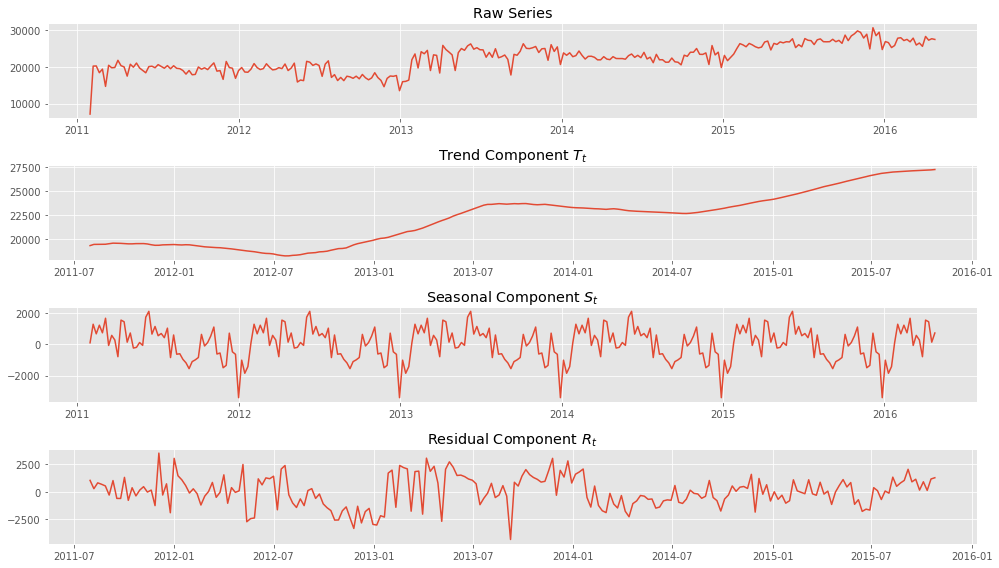

In [128]:
python_decomposition1 = sm.tsa.seasonal_decompose(df33)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, df33, python_decomposition1)
plt.tight_layout()

In [127]:
df1

,HOBBIES
date,
2011-01-29,3764
2011-01-30,3357
2011-01-31,2682
2011-02-01,2669
2011-02-02,1814
...,...
2016-04-20,3472
2016-04-21,3353
2016-04-22,4085


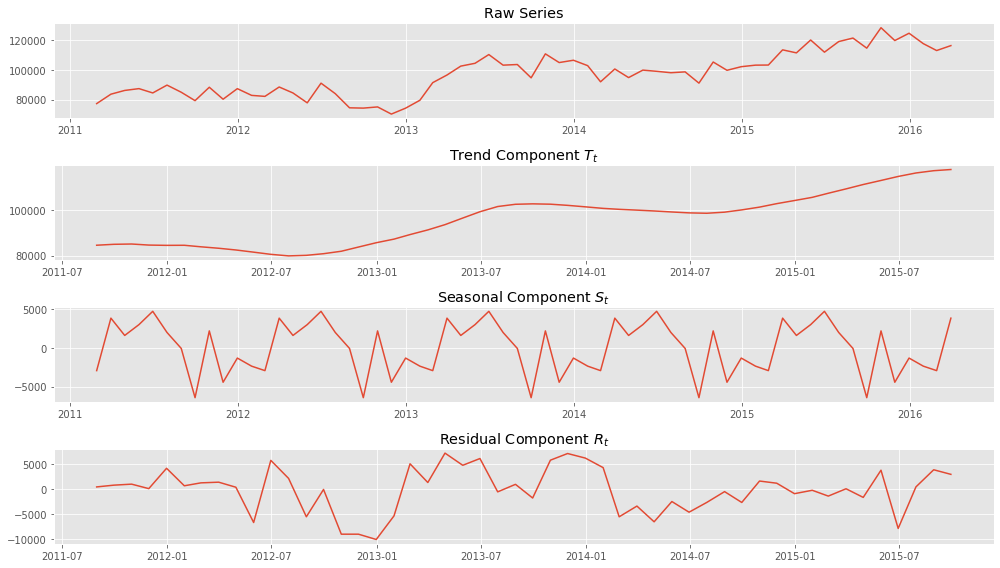

In [134]:
df44 = df1.copy()
df44 = df44.resample('M').sum()
df44 = df44.iloc[1:, :]
df44 = df44.iloc[:-1, :]

python_decomposition1 = sm.tsa.seasonal_decompose(df44)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, df44, python_decomposition1)
plt.tight_layout()

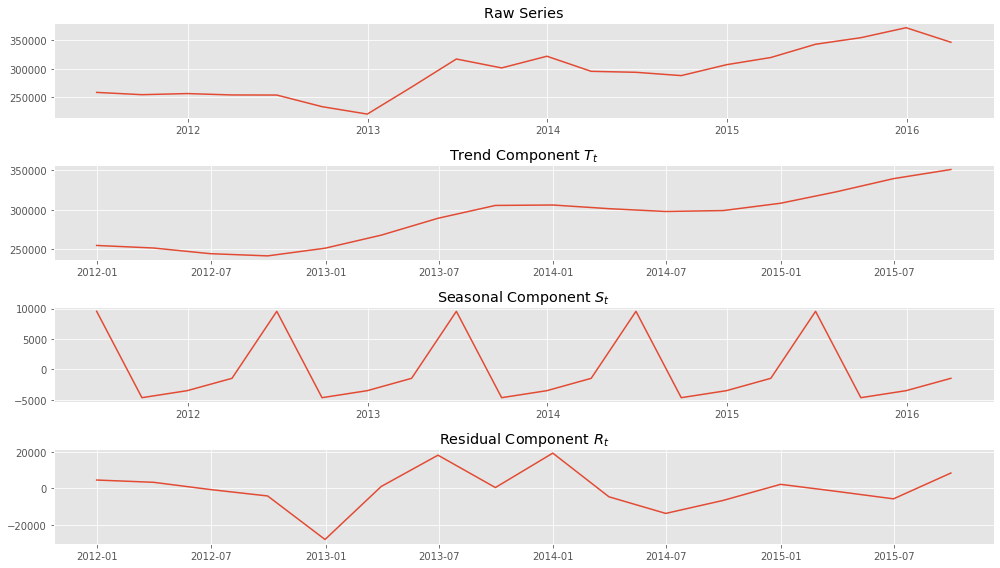

In [142]:
df55 = df1.copy()
df55 = df55.resample('Q').sum()
df55 = df55.iloc[1:, :]
df55 = df55.iloc[:-1, :]

python_decomposition1 = sm.tsa.seasonal_decompose(df55)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, df55, python_decomposition1)
plt.tight_layout()

In [143]:
sm.tsa.seasonal_decompose(df55).trend

,HOBBIES
date,
2011-06-30,NaN
2011-09-30,NaN
2011-12-31,254891.375
2012-03-31,251661.125
2012-06-30,244487.625
2012-09-30,241702.125
2012-12-31,251404.125
2013-03-31,267915.375
2013-06-30,289241.125


In [144]:
sm.tsa.seasonal_decompose(df55).seasonal

,HOBBIES
date,
2011-06-30,9553.679688
2011-09-30,-4628.445312
2011-12-31,-3476.039062
2012-03-31,-1449.195312
2012-06-30,9553.679688
2012-09-30,-4628.445312
2012-12-31,-3476.039062
2013-03-31,-1449.195312
2013-06-30,9553.679688
